In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
sns.set_style('whitegrid')

## Question 1

In [627]:
def density(height_in_ft):
  temp = 288.16-6.5*0.001*height_in_ft*0.3048
  g = 9.80665
  return 1.225*(temp/288.16)**((g/(287*6.5*0.001))-1)

In [628]:
def speed_of_sound(height_in_ft):
    temp = 288.16-6.5*0.001*height_in_ft*0.3048
    return np.sqrt(1.4*temp*287)

In [636]:
def fuel(speed, density, mass=65300, surface_area=124.65):
    cLi = mass*2*9.80665/speed**2/density/surface_area
    cD = 0.024+0.041*cLi**2
    thrust = mass*9.80665*cD/cLi
    fuel = 0.891*(1+speed/4600)*thrust/1000
    return fuel

In [637]:
input = np.arange(100,250,1)
output = [fuel(i, density(28000)) for i in input]


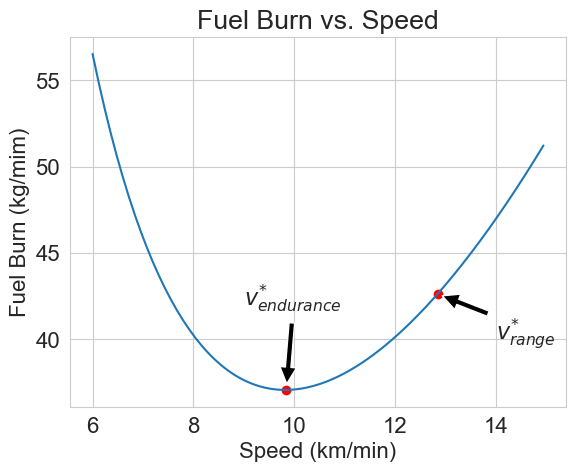

In [657]:
fig, ax = plt.subplots()
ax.plot(input*60/1000, output)
ax.set(xlabel='Speed (km/min)',
       ylabel='Fuel Burn (kg/mim)',
       title='Fuel Burn vs. Speed')
plt.annotate('$v^{*}_{endurance}$', xy=(9.84, np.min(output)), xytext=(9, 42),
             arrowprops=dict(facecolor='black', shrink=0.08))
plt.scatter(9.84, np.min(output), color='red')
plt.annotate('$v^{*}_{range}$', xy=(12.84,output[np.argmin(output/input)]), xytext=(14, 40),
             arrowprops=dict(facecolor='black', shrink=0.08))
plt.scatter(12.84, output[np.argmin(output/input)], color='red')
plt.savefig('q1.png')

In [641]:
(input*60/1000)[np.argmin(output)]

9.84

In [649]:
(input*60/1000)[np.argmin(output/input)]

12.84

## Question 3

In [666]:
import gurobipy as gp
candidate_fares = np.arange(50, 1050, 50, dtype=np.float64)
def demand(price):
    return 100000*price**-1.05+600000000*price**-3
q_vars = ['q'+str(int(i)) for i in candidate_fares]
di = [demand(i) for i in candidate_fares]


In [667]:
m = gp.Model()
vars = m.addVars(q_vars, vtype=gp.GRB.INTEGER)
expr = gp.quicksum(vars['q' + str(int(candidate_fares[i]))] / int(di[i]) for i in range(20))
m.addConstr(expr <= 1)
m.addConstr(gp.quicksum(vars['q' + str(i)] for i in range(50, 1050, 50)) == 150)

<gurobi.Constr *Awaiting Model Update*>

In [668]:
def eval_objective(vars):
    revenue = 0
    price = 50
    for i in q_vars:
        revenue += vars[i] * price
        price += 50
    return revenue

In [669]:
m.setObjective(eval_objective(vars), gp.GRB.MAXIMIZE)
m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xd031767e
Variable types: 0 continuous, 20 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [5e+01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve time: 0.00s
Presolved: 2 rows, 20 columns, 40 nonzeros
Variable types: 0 continuous, 20 integer (0 binary)
Found heuristic solution: objective 75400.000000

Root relaxation: objective 7.555042e+04, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 75550.4174    0    2 75400.0000 75550.4174  0.20%     -    0s
H    0     0                    75500.000000 75550

In [670]:
for i in q_vars:
    print(vars[i].X)

0.0
0.0
62.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
87.0
0.0
0.0
0.0
1.0
0.0


In [671]:
candidate_fares

array([  50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,  450.,
        500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,  900.,
        950., 1000.])

## Question 4

In [684]:
demand = np.repeat(50, 15)
demand = np.concatenate([np.array([0]), demand])

In [685]:
def supply(t):
    first = np.repeat(30, t-7)
    second = np.repeat(60, 22-t)
    return np.concatenate([np.array([0]),first, second])

In [686]:
def actual_departure(demand_profile, supply):    
    demand = 0
    dt = []
    for i in range(demand_profile.shape[0]):
        demand += demand_profile[i]
        discharge = min(demand, supply[i])
        dt.append(discharge)
        demand = demand - discharge
    dt = np.array(dt)
    return dt

/var/folders/zt/r0cp56bx0xn7645kcytd7mzr0000gn/T/ipykernel_5557/1123047650.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set(xlim=(0,15),


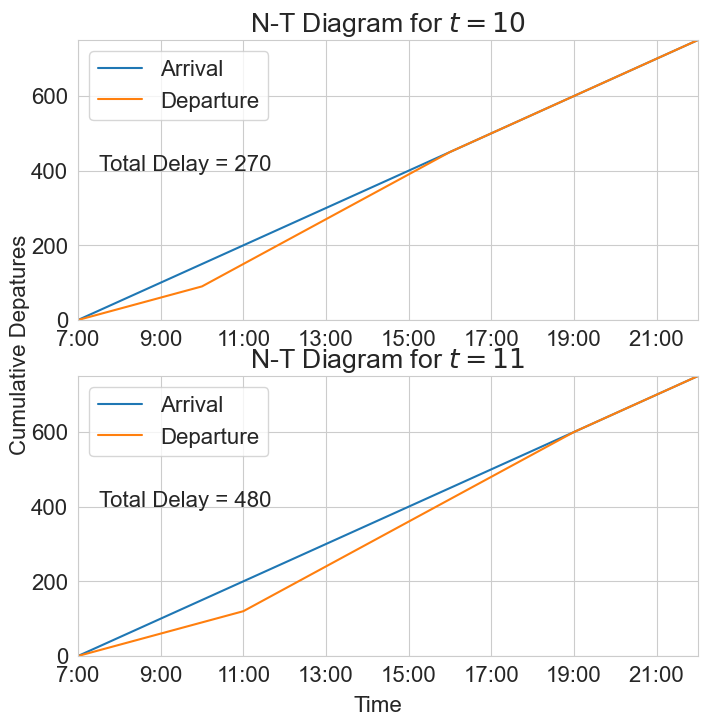

In [700]:
fig, ax = plt.subplots(nrows=2, figsize=(8,8))
sns.lineplot(np.cumsum(demand), ax=ax[0], label='Arrival')
sns.lineplot(np.cumsum(actual_departure(demand, supply(10))), ax=ax[0], label='Departure')
sns.lineplot(np.cumsum(demand), ax=ax[1], label='Arrival')
sns.lineplot(np.cumsum(actual_departure(demand, supply(11))), ax=ax[1],label='Departure')
for i in range(2):
    ax[i].set(xlim=(0,15),
              ylim=(0,750),
              xticklabels=[str(i) +':00' for i in range(7, 23,2)],
              title='N-T Diagram for $t=' + str(i+10) +'$')
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Cumulative Depatures', va='center', rotation='vertical')
ax[0].text(0.5, 400, f'Total Delay = {30*3**2}')
ax[1].text(0.5, 400, f'Total Delay = {30*4**2}')
plt.savefig('q2.png');


## Question 5

In [622]:
def find_tp_star(cost_index):
    expected_cost = []
    candidate = np.arange(2,5.1,0.1)
    for tp in candidate:
        scen1 = (tp-2)/3*30*tp**2

        t = (5-tp)/2+tp
        x = (5-tp)/4
        z = 5*(t-tp-x)
        area1 = (t-tp-x)*60*x*0.5
        area2 = (t-tp-x)*(150*tp-30*tp-60*x)
        area3 = (t-tp-x)*60*z*0.5


        scen2 = (1-(tp-2)/3)*(cost_index*(area1+area2+area3)+30*tp**2)
        expected_cost.append(scen1+scen2)
    expected_cost = np.array(expected_cost)

    return candidate[np.argmin(expected_cost)]

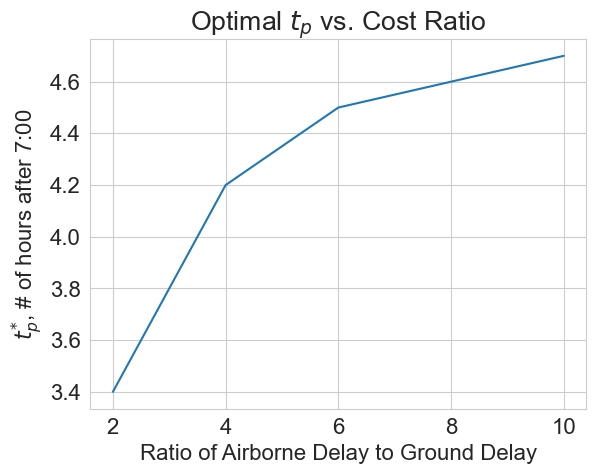

In [708]:
fig, ax = plt.subplots()
tp = [find_tp_star(i) for i in range(2,12,2)]
plt.plot(np.arange(2,12,2), tp)
ax.set(title='Optimal $t_{p}$ vs. Cost Ratio',
       xlabel='Ratio of Airborne Delay to Ground Delay',
       ylabel='$t_{p}^{*}$, # of hours after 7:00');
plt.savefig('q4.png')